# Pretty Cities
The goal of this notebook is to classify cities designated as "pretty". We load images from the google street view API and rate them manually, then we train a model on the ratings (0-10). 

Mostly stolen from [here](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_from_scratch.ipynb#scrollTo=F6txPkRvUE-U)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.version.VERSION


2021-11-26 17:31:16.975484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib:/usr/local/lib
2021-11-26 17:31:16.975517: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.7.0'

## Load the data from somewhere? 

In [27]:
!mkdir -p cache
!mkdir -p data
!ls data
!pwd

5  6  8
/home/y/workspace/PrettyCities



Load dataset into tf



In [38]:
image_size = (180, 180)
batch_size = 32
dataset = 'data/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset,
    labels='inferred',
    label_mode='int',
#    validation_split=0.2,
#    subset="training",
#    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset,
    labels='inferred',
    label_mode='int',
    validation_split=0.232,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 4 files belonging to 3 classes.
Found 4 files belonging to 3 classes.
Using 0 files for validation.


## Display some pics

In [36]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

2021-11-26 17:51:45.311252: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: slice index 4 of dimension 0 out of bounds.


InvalidArgumentError: slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

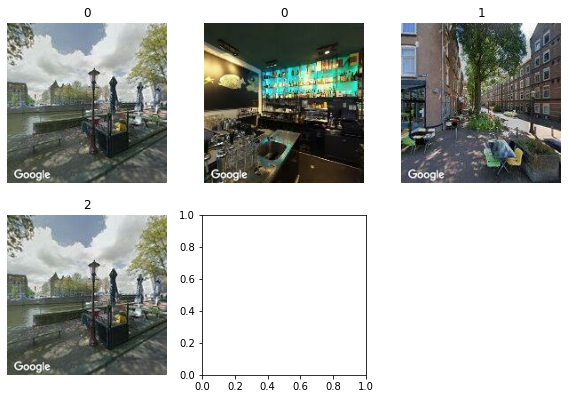

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Augment data

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Buffer data

In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Make model

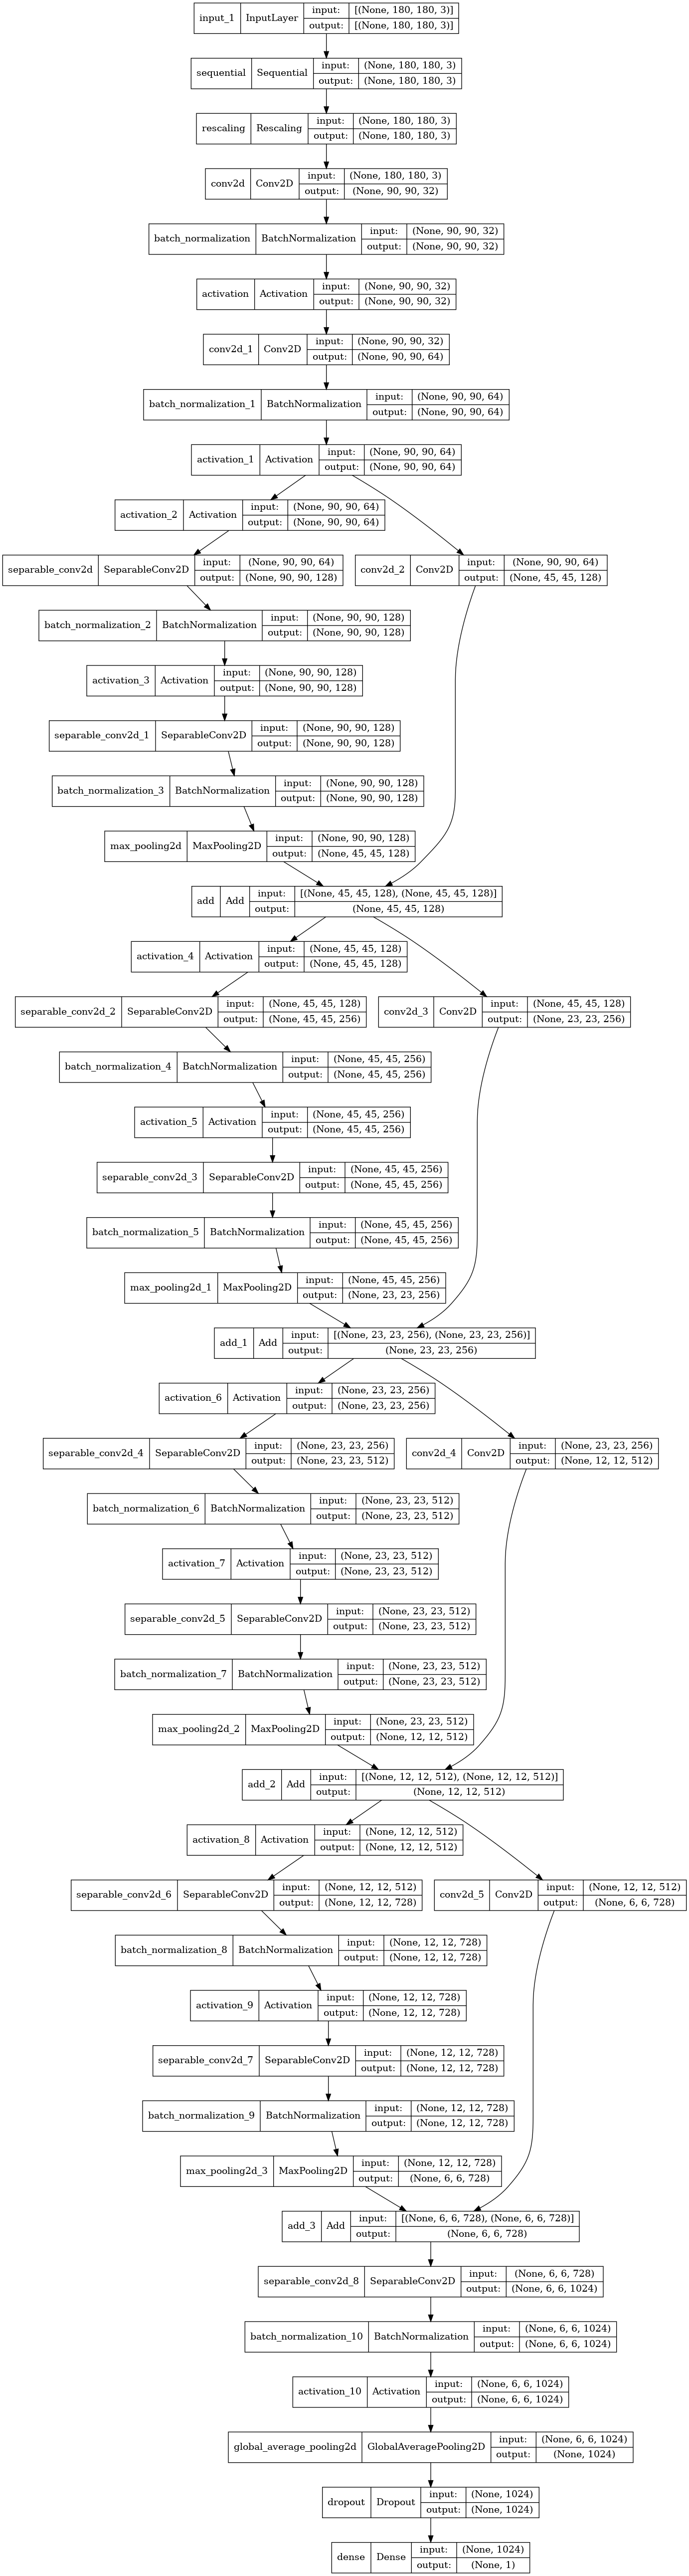

In [6]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

Run things

In [7]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("cache/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)
# save our model
model.save('cache/complete.model')

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.5058 - accuracy: 1.0000 - val_loss: 0.7035 - val_accuracy: 0.0000e+00


/home/y/.local/share/virtualenvs/PrettyCities-88hOkWzh/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/50
1/1 [==============================] - 1s 582ms/step - loss: 0.3603 - accuracy: 1.0000 - val_loss: 0.7136 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 1s 552ms/step - loss: 0.3295 - accuracy: 1.0000 - val_loss: 0.7244 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 1s 676ms/step - loss: 0.1177 - accuracy: 1.0000 - val_loss: 0.7353 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 1s 539ms/step - loss: 0.1890 - accuracy: 1.0000 - val_loss: 0.7464 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 1s 557ms/step - loss: 0.0868 - accuracy: 1.0000 - val_loss: 0.7578 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 1s 546ms/step - loss: 0.0407 - accuracy: 1.0000 - val_loss: 0.7691 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 1s 632ms/step - loss: 0.0727 - accuracy: 1.0000 - val_loss: 0.7809 - val_accuracy: 0.0

2021-11-26 17:32:35.766541: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


KeyError: "Failed to add concrete function 'b'__inference_model_layer_call_fn_33262'' to object-based SavedModel as it captures tensor <tf.Tensor: shape=(), dtype=resource, value=<Resource Tensor>> which is unsupported or not reachable from root. One reason could be that a stateful object or a variable that the function depends on is not assigned to an attribute of the serialized trackable object (see SaveTest.test_captures_unreachable_variable)."

## Load the new model

In [ ]:
new_model = tf.keras.models.load_model('cache/complete.model')


In [ ]:
img = keras.preprocessing.image.load_img(
   'imgtoload', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)